# Предсказание ошибок

Нерадивый ML-инженер Тензорослав обучал линейную регрессию на некотором датасете.
Однако, он не был знаком с градиентными методами оптимизации,
поэтому Тензорослав решил искать оптимум с помощью случайного поиска. Для этого
он сгенерировал несколько случайных векторов весов и считал среднеквадратичную
ошибку ($MSE$) для каждого вектора. Однако в какой-то момент Тензорослав
случайно удалил выборку, на которой он считал $MSE$.

Помогите Тензорославу закончить начатое и предскажите значение $MSE$ для
тех векторов весов, которые он еще не успел обработать.

## О датасете
Вам предлагаются три файла:

- train_weights.csv - содержит значения весов в колонках $W_0–W_9$
($10$-мерные векторы) и соответствующие значения $MSE$ в колонке $MSE$
- test_weights.csv - содержит тестовые векторы весов (для которых нужно предсказать $MSE$)
- example - пример корректной посылки в контест

## Что нужно сделать

Необходимо предсказать колонку $MSE$ для векторов из файла test_weights.csv и загрузить файл answers в формате, аналогичном примеру.
### Критерий оценки:
Корень из средней квадратичной логарифмической ошибки ($RMSLE$).

Баллы рассчитываются по формуле:
$100 * max(min((0.3 - RMSLE)\space /\space 0.1,\space 1),\space 0)$

Для максимального балла ($100$) необходимо достичь $RMSLE ≤ 0.2$.

### Требуемый формат вывода
Файл answers (без пробелов в названии) в формате JSON (смотри example.txt)

# Подготовка данных

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Загрузим данные:

In [2]:
test = pd.read_csv("test_weights.csv")
train = pd.read_csv("train_weights.csv")

Разделим признаки и таргет:

In [15]:
X = train.drop(columns=['MSE'])
y = train['MSE']
X_test = test.copy()

# Feature Engineering

Посмотрим на распределение $MSE$:

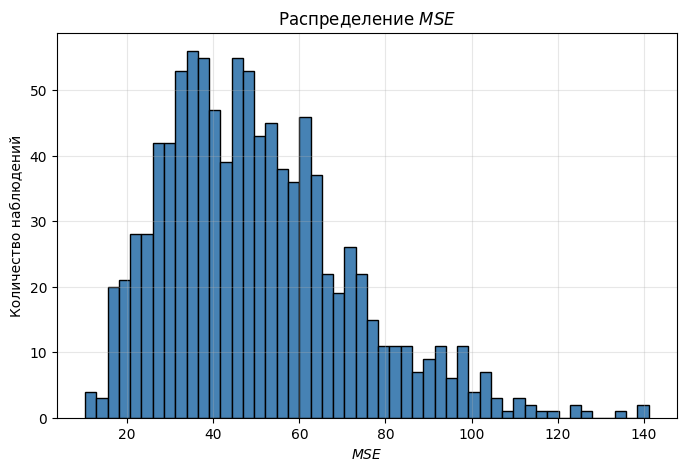

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(y, bins=50, color='steelblue', edgecolor='black')
plt.title(r"Распределение $MSE$")
plt.xlabel(r"$MSE$")
plt.ylabel("Количество наблюдений")
plt.grid(alpha=0.3)
plt.show()

На гистограмме видим большой разброс значений, основные сконцентрированы в пределах $30-60$, но имеются выбросы даже до $140$.
Такие образом, распределение асимметрично и имеет длинный хвост больших значений.
Для дальнейшего анализа логарифмируем эти значения, чтобы приблизить распределение к нормальному.

P.S. так как для оценки решения используется метрика $RMSLE$, которая сравнивает логарифмы предсказаний и реальных оценок, заранее логарифмируя таргет, мы учим модель минимизировать именно разницу логарифмов.

$$
y_{\text{log}} = \log(1 + MSE)
$$

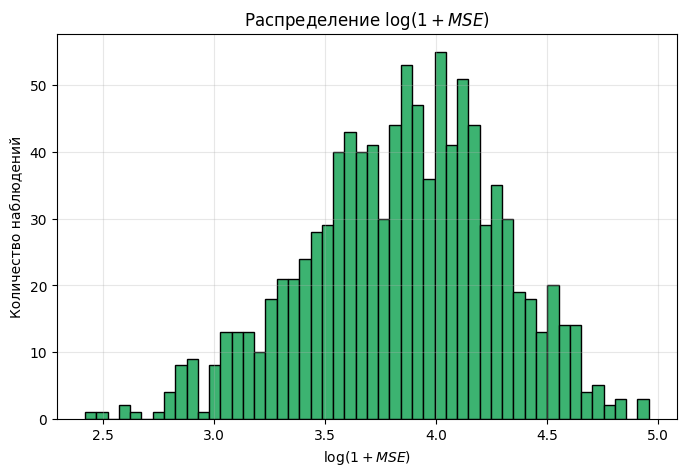

In [17]:
y_log = np.log1p(y)

plt.figure(figsize=(8, 5))
plt.hist(y_log, bins=50, color='mediumseagreen', edgecolor='black')
plt.title(r"Распределение $\log(1 + MSE)$")
plt.xlabel(r"$\log(1 + MSE)$")
plt.ylabel("Количество наблюдений")
plt.grid(alpha=0.3)
plt.show()

Распределение стало больше похоже на нормальное, исчез длинный хвост больших значений и основная масса значений расположена в центре.

# Обучение

Для оценки качества будет использоваться метрика $RMSLE$, поэтому мы должны выбрать модели, устойчивые к масштабам и разным диапазонам. Метрика меньше наказывает за абсолютные ошибки, но сильнее за недооценку малых значений, поэтому модели, которые склонны "усреднять" (как линейные), могут быть менее точны.

$$
RMSLE=\sqrt{\frac{1}{n}\sum^n_{i=1}(\log(1+\hat{y_i})-\log(1+y_i))^2}
$$

P.S. $+1$ в логарифме используется, чтобы избежать проблем при $y=0$.

Импортируем необходимые библиотеки и определим функцию $RMSLE$:

In [ ]:
import json

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error


def rmsle(y_true, y_pred):
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Выберем несколько моделей для обучения, потом сравним их и определим лучшую для этой задачи. 

## Выбор модели

### 1. Полиномиальная регрессия с L2 регуляризацией.

$MSE$ исходной линейной модели - это квадратичная функция от весов $w$. Полиномиальные признаки 2 степени прямо восстанавливают такую форму (квадратичную поверхность).

Так как мы хотим тренировать модель не на исходных $y$, а на их логарифме, но потом предсказывать в исходном масштабе, используем `TransformedTargetRegressor`:
- во время `.fit()` он применяет `func` к $y$
- во время `.predict()` применяет `inverse_func` к предсказанию

Применяем `StandardScaler`, чтобы отмасштабировать признаки:
$$
z = \frac{x-\mu}{\sigma}
$$

После этого каждый признак имеет среднее ~$0$, стандартное отклонение ~$1$.

Выберем $L2$ (Ridge) регуляризацию, потому что после `PolynomialFeatures` признаки сильно коррелированы, $MSE$ - выпуклая функция, а $L2$ стабилизирует решение.
$$
R=\sum^n_{i=1}w^2_i
$$

In [20]:
models = {}

models["poly2_ridge"] = TransformedTargetRegressor(
    regressor=Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("ridge", Ridge(alpha=1.0, random_state=42))
    ]),
    func=np.log1p, inverse_func=np.expm1
)

### 2. Случайный лес

`RandomForestRegressor` устойчив к шуму и выбросам, почему не переобучается и хорош как baseline.

In [21]:
models["rf"] = TransformedTargetRegressor(
    regressor=RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

### 3. Градиентный бустинг

Умеет аппроксимировать сложные, нелинейные зависимости, точно подстраивается под данные и хорошо работает даже с небольшим числом признаков.

P.S. если окажется значительно лучше первых двух моделей, поймём, что есть смысл пробовать более мощные бустинги.

In [22]:
models["gbr"] = TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

## Оценка моделей

Используем кросс-валидацию, чтобы получить более устойчивую оценку путём усреднения результата по нескольким разбиениям.

In [23]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    scores = []
    for tr_idx, va_idx in cv.split(X):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        model.fit(X_tr, y_tr)
        pred = model.predict(X_va)
        scores.append(rmsle(y_va, pred))
    cv_results[name] = (np.mean(scores), np.std(scores))

Выведем сводную таблицу, отсортировав по средней ошибке, выберем лучшую.

In [24]:
print("Cross-validation RMSLE (mean ± std):")
for name, (m, s) in sorted(cv_results.items(), key=lambda kv: kv[1][0]):
    print(f"{name:>14}: {m:.4f} ± {s:.4f}")

best_name, (best_mean, _) = min(cv_results.items(), key=lambda kv: kv[1][0])
best_model = models[best_name]
print(f"\nBest model: {best_name} (CV RMSLE = {best_mean:.4f})")

Cross-validation RMSLE (mean ± std):
   poly2_ridge: 0.1033 ± 0.0072
           gbr: 0.1470 ± 0.0107
            rf: 0.2139 ± 0.0158

Best model: poly2_ridge (CV RMSLE = 0.1033)


Обучаем лучшую модель на всей обучающей выборке и делаем предсказание на тестовых данных:

In [25]:
best_model.fit(X, y)
test_pred = best_model.predict(X_test)
test_pred = np.clip(test_pred, a_min=0, a_max=None)

Сформируем файл answers в заданном формате:

In [26]:
out = X_test.copy()
out["MSE"] = test_pred

records = out.to_dict(orient="records")

with open("answers", "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=4)

print("Saved: answers")

Saved: answers


# Сохраним модель

In [27]:
import joblib

joblib.dump(best_model, "ridge_poly.joblib")

['ridge_poly.joblib']